/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/1759229048.py:204: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(
/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/1759229048.py:216: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(
/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/1759229048.py:231: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(
/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/1759229048.py:237: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(
/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/1759229048.py:166: UserWarning: Setting the 'color' property will override the edgecolor or facecol

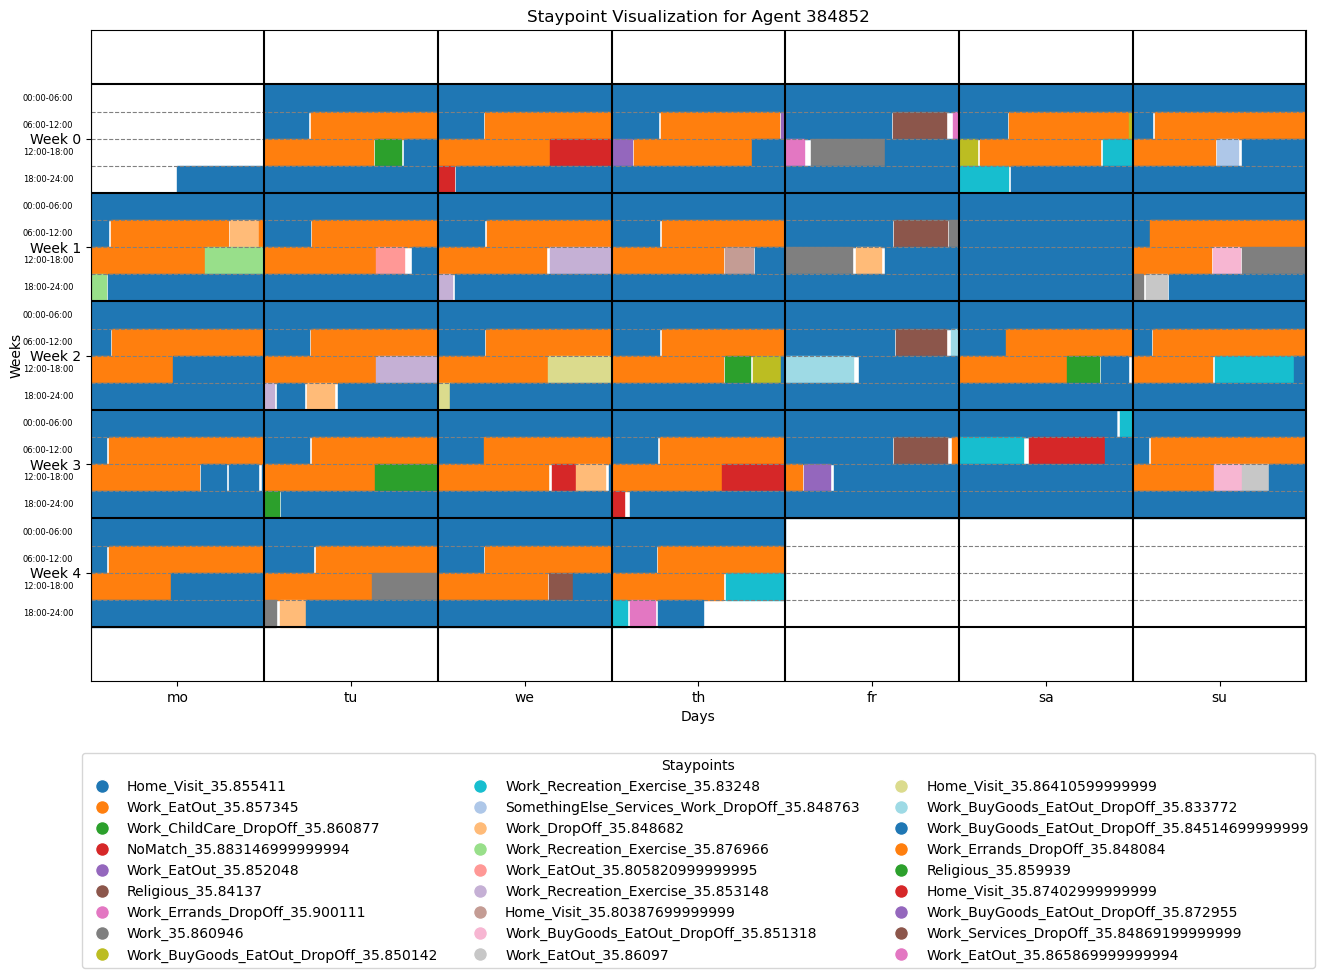

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkb
from matplotlib.lines import Line2D

# --------------------------
# 1. Data Loading & Cleaning
# --------------------------
def set_up_df(agent_id):
    file_path = "/Users/mauryan/Desktop/CalenderPlot_Trial3_GTStaypointsvsMissing/agent_384852_GTStaypoints.parquet"
    df = pd.read_parquet(file_path)
    df = pd.DataFrame(df)
    
    # Convert the binary geometry using wkb.loads
    df['geometry'] = df['geometry'].apply(lambda x: wkb.loads(x) if pd.notnull(x) else None)
    
    # Drop any rows that do not have a Point geometry (i.e., remove LineStrings)
    df = df[df['geometry'].apply(lambda geom: geom is not None and geom.geom_type == "Point")]
    
    # Extract longitude and latitude from the geometry (Points have .x and .y)
    df['longitude'] = df['geometry'].apply(lambda geom: geom.x)
    df['latitude'] = df['geometry'].apply(lambda geom: geom.y)
    
    # Filter to the desired agent
    df = df[df['agent_uid'] == agent_id]
    return df

# --------------------------------
# 2. Time Slot & Week/Day Assignments
# --------------------------------
def assign_time_slot_start(row):
    hour = row['timestamp_start'].hour
    if 0 <= hour < 6:
        return 1
    elif 6 <= hour < 12:
        return 2
    elif 12 <= hour < 18:
        return 3
    else:
        return 4

def assign_time_slot_end(row):
    hour = row['timestamp_end'].hour
    if 0 <= hour < 6:
        return 1
    elif 6 <= hour < 12:
        return 2
    elif 12 <= hour < 18:
        return 3
    else:
        return 4

def update_start_ends(df):
    df['timestamp_start'] = pd.to_datetime(df['timestamp_start'])
    df['timestamp_end'] = pd.to_datetime(df['timestamp_end'])
    
    df['time_slot'] = df.apply(assign_time_slot_start, axis=1)
    df['time_slot_end'] = df.apply(assign_time_slot_end, axis=1)
    df['week'] = df['timestamp_start'].dt.isocalendar().week
    df['end_week'] = df['timestamp_end'].dt.isocalendar().week
    df['day'] = df['timestamp_start'].dt.day_name().str[:2].str.lower()
    df['end_day'] = df['timestamp_end'].dt.day_name().str[:2].str.lower()
    df.loc[df['week'] == 52, 'week'] = 0

# --------------------------------
# 3. Semantic Label Modification
# --------------------------------
def modify_semantic_label(row):
    # If semantic_label is missing, set it to 'unknown'
    label = row['semantic_label'] if pd.notnull(row['semantic_label']) else "unknown"
    return f"{label}_{row['longitude']}"

# --------------------------
# 4. Visualization
# --------------------------
def visualize_data(df, selected_agent):
    # Fixed color palette.
    colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
        "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
        "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
        "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5"
    ]
    
    # Modify semantic labels and assign each a unique color.
    df['semantic_label'] = df.apply(modify_semantic_label, axis=1)
    unique_labels = df['semantic_label'].unique()
    label_color_map = { label: colors[i % len(colors)] for i, label in enumerate(unique_labels) }
    df['color'] = df['semantic_label'].map(label_color_map)

    # Pivot table: rows = week, columns = day (ordered by day_order).
    day_order = ['mo', 'tu', 'we', 'th', 'fr', 'sa', 'su']
    pivot_data = df.pivot_table(
        index='week', columns='day',
        values='semantic_label',
        aggfunc=lambda x: ', '.join(x)
    )[day_order]

    # Reindex pivot_data to include every week in the range.
    min_week = df['week'].min()
    max_week = df['week'].max()
    all_weeks = list(range(min_week, max_week + 1))
    pivot_data = pivot_data.reindex(index=all_weeks)

    # Relabel weeks in ascending order: earliest week becomes Week 0, next Week 1, etc.
    n_weeks = len(all_weeks)
    new_week_labels = { orig: new for new, orig in enumerate(all_weeks) }
    # Sort pivot_data in ascending order so that the lowest new label is earliest.
    pivot_data = pivot_data.sort_index(ascending=True)

    # Calculate fractional time slot positions.
    df['time_slot_start_number'] = df['timestamp_start'].dt.hour // 6
    df['time_slot_end_number'] = df['timestamp_end'].dt.hour // 6
    df['time_slot_start'] = (
        (df['timestamp_start'].dt.hour / 6)
        + (df['timestamp_start'].dt.minute / 360)
        + (df['timestamp_start'].dt.second / 2160)
    ) - df['time_slot_start_number']
    df['time_slot_end'] = (
        (df['timestamp_end'].dt.hour / 6)
        + (df['timestamp_end'].dt.minute / 360)
        + (df['timestamp_end'].dt.second / 2160)
    ) - df['time_slot_end_number']

    # Helper function for sub-row vertical offset.
    # We want sub-rows (chunks) ordered so that:
    #   chunk 0 (00:00-06:00) is at the TOP of the cell,
    #   chunk 1 (06:00-12:00) is next,
    #   chunk 2 (12:00-18:00) follows,
    #   chunk 3 (18:00-24:00) is at the BOTTOM.
    # Since we later invert the y-axis, we define chunk_y so that in data coordinates:
    #   chunk 0: y = cell_row
    #   chunk 1: y = cell_row + 0.25
    #   chunk 2: y = cell_row + 0.50
    #   chunk 3: y = cell_row + 0.75
    def chunk_y(cell_row, chunk_index):
        return cell_row + (chunk_index * 0.25)

    # Create the figure.
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Iterate over weeks (rows) and days (columns). The cell row for a week is given by new_week_labels.
    for orig_week, row_data in pivot_data.iterrows():
        cell_row = new_week_labels[orig_week]
        for j, day in enumerate(day_order):
            # Draw the border rectangle for the cell.
            ax.add_patch(plt.Rectangle((j, cell_row), 1, 1, fill=False,
                                       edgecolor='none', linewidth=2))
            # For each of the 4 sub time slots in the day:
            for k in range(4):
                staypoints = df[
                    (df['week'] == orig_week)
                    & (df['day'] == day)
                    & (df['time_slot_start_number'] == k)
                ]
                for idx, (_, row) in enumerate(staypoints.iterrows()):
                    start_pos = row['time_slot_start']
                    end_pos = row['time_slot_end']
                    x_pos = j + start_pos
                    num_k = row['time_slot_start_number']
                    num_k_end = row['time_slot_end_number']
                    
                    # CASE 1: Staypoint spans a single adjacent slot on the same day.
                    if ((num_k + 1) == num_k_end) and (row['day'] == row['end_day']):
                        ax.add_patch(plt.Rectangle(
                            (x_pos, chunk_y(cell_row, num_k)),
                            1 - start_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                        ax.add_patch(plt.Rectangle(
                            (j, chunk_y(cell_row, num_k_end)),
                            end_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                    # CASE 2: Spans two slots with a full slot in between.
                    elif ((num_k + 2) == num_k_end) and (row['day'] == row['end_day']):
                        ax.add_patch(plt.Rectangle(
                            (x_pos, chunk_y(cell_row, num_k)),
                            1 - start_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                        ax.add_patch(plt.Rectangle(
                            (j, chunk_y(cell_row, num_k_end - 1)),
                            1, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                        ax.add_patch(plt.Rectangle(
                            (j, chunk_y(cell_row, num_k + 1)),
                            end_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                    # CASE 3: Entirely within one time slot.
                    elif (num_k == num_k_end) and (row['day'] == row['end_day']):
                        rect_width = end_pos - start_pos
                        ax.add_patch(plt.Rectangle(
                            (x_pos, chunk_y(cell_row, num_k)),
                            rect_width, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                    # CASE 4: Overflows into the next time slot/day.
                    else:
                        l = num_k
                        ax.add_patch(plt.Rectangle(
                            (x_pos, chunk_y(cell_row, l)),
                            1 - start_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                        l += 1
                        r = j
                        new_cell_row = cell_row
                        placeholder_day = day
                        while (l != num_k_end) or (placeholder_day != row['end_day']):
                            if (l == 4) and (placeholder_day != 'su'):
                                l = 0
                                ax.add_patch(plt.Rectangle(
                                    (r + 1, chunk_y(new_cell_row, 0)),
                                    end_pos, 0.25,
                                    color=row["color"], edgecolor='none'
                                ))
                                current_day_index = day_order.index(placeholder_day)
                                next_day_index = (current_day_index + 1) % len(day_order)
                                placeholder_day = day_order[next_day_index]
                                r += 1
                            elif (l == 4) and (placeholder_day == 'su'):
                                l = 0
                                r = 0
                                placeholder_day = 'mo'
                                new_cell_row += 1
                            else:
                                ax.add_patch(plt.Rectangle(
                                    (r, chunk_y(new_cell_row, l)),
                                    1, 0.25,
                                    color=row["color"], edgecolor='none'
                                ))
                                l += 1
                        ax.add_patch(plt.Rectangle(
                            (r, chunk_y(new_cell_row, l)),
                            end_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))

    # ---------------------------
    # Draw delineation lines
    # ---------------------------
    ax.set_ylim(-0.5, n_weeks + 0.5)
    
    # Solid horizontal lines for each week boundary.
    for row_i in range(n_weeks + 1):
        ax.axhline(y=row_i, color='black', linewidth=1.5)
    
    # Dashed horizontal lines for each 6-hour sub-interval (0.25 steps).
    for row_i in range(n_weeks):
        for sub in [0.25, 0.5, 0.75]:
            ax.axhline(y=row_i + sub, color='gray', linestyle='--', linewidth=0.8)
    
    # Vertical lines for day boundaries.
    for day_index in range(len(day_order) + 1):
        ax.axvline(x=day_index, color='black', linewidth=1.5)
    
    ax.set_xlim(0, len(day_order))
    ax.set_xticks(np.arange(len(day_order)) + 0.5)
    ax.set_xticklabels(day_order)
    
    # Set y-ticks centered in each week cell with the new week labels.
    ax.set_yticks(np.arange(n_weeks) + 0.5)
    new_labels = [f"Week {new_week_labels[orig]}" for orig in sorted(new_week_labels.keys())]
    ax.set_yticklabels(new_labels)
    
    ax.set_xlabel('Days')
    ax.set_ylabel('Weeks')
    ax.set_title(f"Staypoint Visualization for Agent {selected_agent}")
    
    # Add a legend.
    legend_elements = [
        Line2D([0], [0], marker='o', color='w',
               markerfacecolor=label_color_map[label],
               markersize=10, label=label)
        for label in unique_labels
    ]
    ax.legend(handles=legend_elements, title="Staypoints",
              loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    
    # Invert the y-axis so that the smallest week (Week 0, earliest) appears at the top.
    ax.invert_yaxis()
    
    # ---------------------------
    # Add Time Block Labels next to each sub-row.
    # ---------------------------
    # Define time block labels in order from top to bottom.
    # Since we inverted the y-axis, the top sub-row of each cell now corresponds to chunk 0.
    time_labels = ["00:00-06:00", "06:00-12:00", "12:00-18:00", "18:00-24:00"]
    # For each week cell, add text for each sub-row (placed at x = -0.1).
    for orig_week in all_weeks:
        cell_row = new_week_labels[orig_week]
        # Compute the midpoints of each sub-row within the cell.
        for chunk in range(4):
            # The sub-row's midpoint is cell_row + (chunk * 0.25) + 0.125.
            y_mid = cell_row + (chunk * 0.25) + 0.125
            # Place the text at x = -0.1 (adjust as needed) with right alignment.
            ax.text(-0.1, y_mid, time_labels[chunk], va='center', ha='right', fontsize=6, color='black')
    
    plt.tight_layout()
    plt.show()

# --------------------------
# Main Execution
# --------------------------
if __name__ == "__main__":
    selected_agent = 384852
    df = set_up_df(selected_agent)
    update_start_ends(df)
    visualize_data(df, selected_agent)

/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/2405229639.py:204: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(
/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/2405229639.py:216: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(
/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/2405229639.py:231: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(
/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/2405229639.py:237: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(
/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/2405229639.py:166: UserWarning: Setting the 'color' property will override the edgecolor or facecol

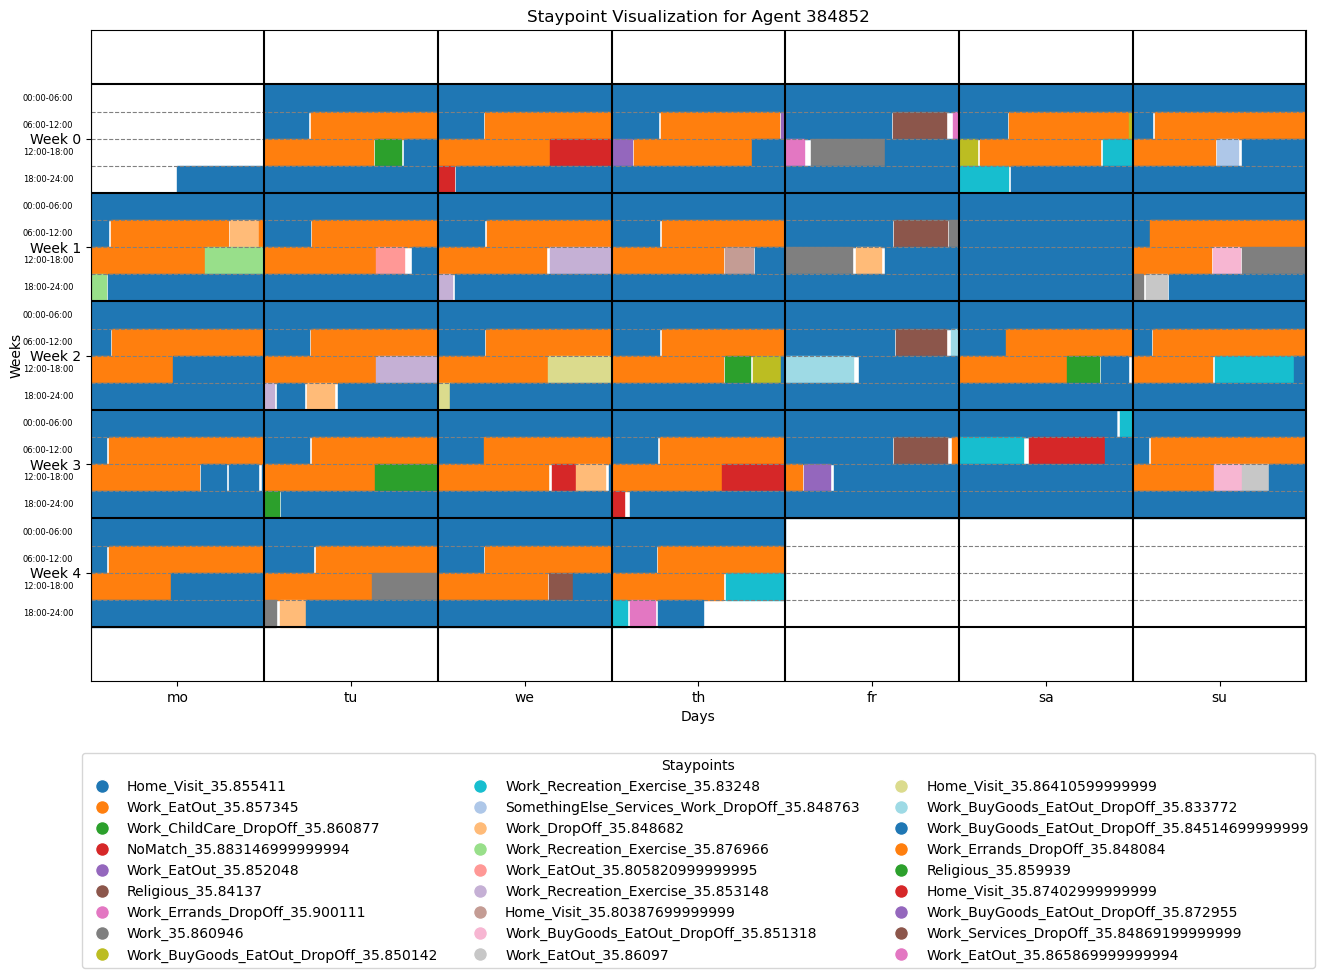

/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/2405229639.py:535: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(
/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/2405229639.py:547: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(
/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/2405229639.py:562: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(
/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/2405229639.py:568: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(
/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/2405229639.py:497: UserWarning: Setting the 'color' property will override the edgecolor or facecol

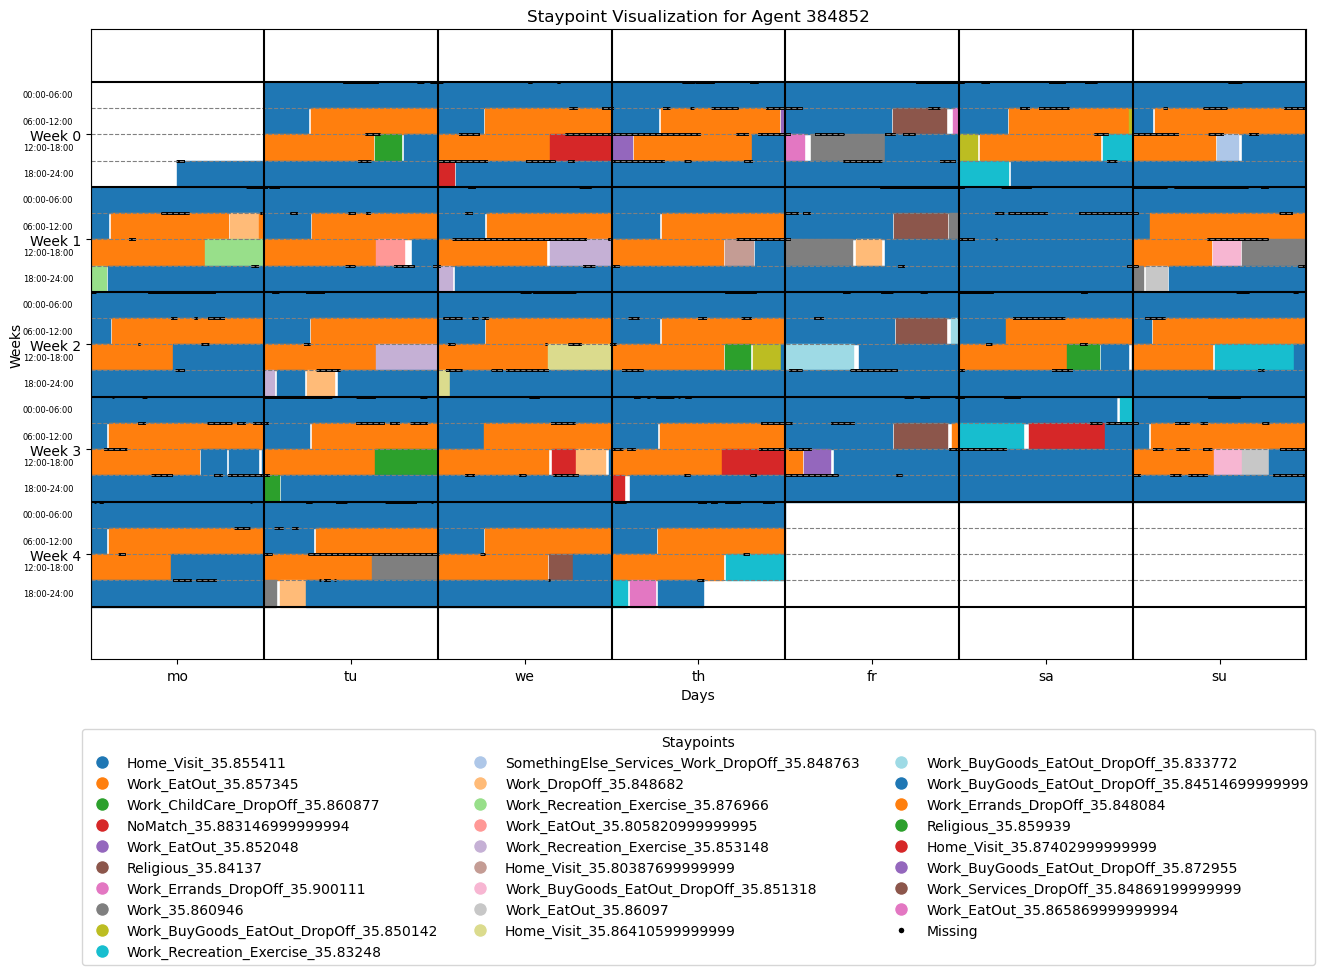

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkb
from matplotlib.lines import Line2D

# --------------------------
# 1. Data Loading & Cleaning
# --------------------------
def set_up_df(agent_id):
    file_path = "/Users/mauryan/Desktop/CalenderPlot_Trial3_GTStaypointsvsMissing/agent_384852_GTStaypoints.parquet"
    df = pd.read_parquet(file_path)
    df = pd.DataFrame(df)
    
    # Convert the binary geometry using wkb.loads
    df['geometry'] = df['geometry'].apply(lambda x: wkb.loads(x) if pd.notnull(x) else None)
    
    # Drop any rows that do not have a Point geometry (i.e., remove LineStrings)
    df = df[df['geometry'].apply(lambda geom: geom is not None and geom.geom_type == "Point")]
    
    # Extract longitude and latitude from the geometry (Points have .x and .y)
    df['longitude'] = df['geometry'].apply(lambda geom: geom.x)
    df['latitude'] = df['geometry'].apply(lambda geom: geom.y)
    
    # Filter to the desired agent
    df = df[df['agent_uid'] == agent_id]
    return df

# --------------------------------
# 2. Time Slot & Week/Day Assignments
# --------------------------------
def assign_time_slot_start(row):
    hour = row['timestamp_start'].hour
    if 0 <= hour < 6:
        return 1
    elif 6 <= hour < 12:
        return 2
    elif 12 <= hour < 18:
        return 3
    else:
        return 4

def assign_time_slot_end(row):
    hour = row['timestamp_end'].hour
    if 0 <= hour < 6:
        return 1
    elif 6 <= hour < 12:
        return 2
    elif 12 <= hour < 18:
        return 3
    else:
        return 4

def update_start_ends(df):
    df['timestamp_start'] = pd.to_datetime(df['timestamp_start'])
    df['timestamp_end'] = pd.to_datetime(df['timestamp_end'])
    
    df['time_slot'] = df.apply(assign_time_slot_start, axis=1)
    df['time_slot_end'] = df.apply(assign_time_slot_end, axis=1)
    df['week'] = df['timestamp_start'].dt.isocalendar().week
    df['end_week'] = df['timestamp_end'].dt.isocalendar().week
    df['day'] = df['timestamp_start'].dt.day_name().str[:2].str.lower()
    df['end_day'] = df['timestamp_end'].dt.day_name().str[:2].str.lower()
    df.loc[df['week'] == 52, 'week'] = 0

# --------------------------------
# 3. Semantic Label Modification
# --------------------------------
def modify_semantic_label(row):
    # If semantic_label is missing, set it to 'unknown'
    label = row['semantic_label'] if pd.notnull(row['semantic_label']) else "unknown"
    return f"{label}_{row['longitude']}"

# --------------------------
# 4. Visualization
# --------------------------
def visualize_data(df, selected_agent):
    # Fixed color palette.
    colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
        "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
        "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
        "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5"
    ]
    
    # Modify semantic labels and assign each a unique color.
    df['semantic_label'] = df.apply(modify_semantic_label, axis=1)
    unique_labels = df['semantic_label'].unique()
    label_color_map = { label: colors[i % len(colors)] for i, label in enumerate(unique_labels) }
    df['color'] = df['semantic_label'].map(label_color_map)

    # Pivot table: rows = week, columns = day (ordered by day_order).
    day_order = ['mo', 'tu', 'we', 'th', 'fr', 'sa', 'su']
    pivot_data = df.pivot_table(
        index='week', columns='day',
        values='semantic_label',
        aggfunc=lambda x: ', '.join(x)
    )[day_order]

    # Reindex pivot_data to include every week in the range.
    min_week = df['week'].min()
    max_week = df['week'].max()
    all_weeks = list(range(min_week, max_week + 1))
    pivot_data = pivot_data.reindex(index=all_weeks)

    # Relabel weeks in ascending order: earliest week becomes Week 0, next Week 1, etc.
    n_weeks = len(all_weeks)
    new_week_labels = { orig: new for new, orig in enumerate(all_weeks) }
    # Sort pivot_data in ascending order so that the lowest new label is earliest.
    pivot_data = pivot_data.sort_index(ascending=True)

    # Calculate fractional time slot positions.
    df['time_slot_start_number'] = df['timestamp_start'].dt.hour // 6
    df['time_slot_end_number'] = df['timestamp_end'].dt.hour // 6
    df['time_slot_start'] = (
        (df['timestamp_start'].dt.hour / 6)
        + (df['timestamp_start'].dt.minute / 360)
        + (df['timestamp_start'].dt.second / 2160)
    ) - df['time_slot_start_number']
    df['time_slot_end'] = (
        (df['timestamp_end'].dt.hour / 6)
        + (df['timestamp_end'].dt.minute / 360)
        + (df['timestamp_end'].dt.second / 2160)
    ) - df['time_slot_end_number']

    # Helper function for sub-row vertical offset.
    # We want sub-rows (chunks) ordered so that:
    #   chunk 0 (00:00-06:00) is at the TOP of the cell,
    #   chunk 1 (06:00-12:00) is next,
    #   chunk 2 (12:00-18:00) follows,
    #   chunk 3 (18:00-24:00) is at the BOTTOM.
    # Since we later invert the y-axis, we define chunk_y so that in data coordinates:
    #   chunk 0: y = cell_row
    #   chunk 1: y = cell_row + 0.25
    #   chunk 2: y = cell_row + 0.50
    #   chunk 3: y = cell_row + 0.75
    def chunk_y(cell_row, chunk_index):
        return cell_row + (chunk_index * 0.25)

    # Create the figure.
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Iterate over weeks (rows) and days (columns). The cell row for a week is given by new_week_labels.
    for orig_week, row_data in pivot_data.iterrows():
        cell_row = new_week_labels[orig_week]
        for j, day in enumerate(day_order):
            # Draw the border rectangle for the cell.
            ax.add_patch(plt.Rectangle((j, cell_row), 1, 1, fill=False,
                                       edgecolor='none', linewidth=2))
            # For each of the 4 sub time slots in the day:
            for k in range(4):
                staypoints = df[
                    (df['week'] == orig_week)
                    & (df['day'] == day)
                    & (df['time_slot_start_number'] == k)
                ]
                for idx, (_, row) in enumerate(staypoints.iterrows()):
                    start_pos = row['time_slot_start']
                    end_pos = row['time_slot_end']
                    x_pos = j + start_pos
                    num_k = row['time_slot_start_number']
                    num_k_end = row['time_slot_end_number']
                    
                    # CASE 1: Staypoint spans a single adjacent slot on the same day.
                    if ((num_k + 1) == num_k_end) and (row['day'] == row['end_day']):
                        ax.add_patch(plt.Rectangle(
                            (x_pos, chunk_y(cell_row, num_k)),
                            1 - start_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                        ax.add_patch(plt.Rectangle(
                            (j, chunk_y(cell_row, num_k_end)),
                            end_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                    # CASE 2: Spans two slots with a full slot in between.
                    elif ((num_k + 2) == num_k_end) and (row['day'] == row['end_day']):
                        ax.add_patch(plt.Rectangle(
                            (x_pos, chunk_y(cell_row, num_k)),
                            1 - start_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                        ax.add_patch(plt.Rectangle(
                            (j, chunk_y(cell_row, num_k_end - 1)),
                            1, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                        ax.add_patch(plt.Rectangle(
                            (j, chunk_y(cell_row, num_k + 1)),
                            end_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                    # CASE 3: Entirely within one time slot.
                    elif (num_k == num_k_end) and (row['day'] == row['end_day']):
                        rect_width = end_pos - start_pos
                        ax.add_patch(plt.Rectangle(
                            (x_pos, chunk_y(cell_row, num_k)),
                            rect_width, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                    # CASE 4: Overflows into the next time slot/day.
                    else:
                        l = num_k
                        ax.add_patch(plt.Rectangle(
                            (x_pos, chunk_y(cell_row, l)),
                            1 - start_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                        l += 1
                        r = j
                        new_cell_row = cell_row
                        placeholder_day = day
                        while (l != num_k_end) or (placeholder_day != row['end_day']):
                            if (l == 4) and (placeholder_day != 'su'):
                                l = 0
                                ax.add_patch(plt.Rectangle(
                                    (r + 1, chunk_y(new_cell_row, 0)),
                                    end_pos, 0.25,
                                    color=row["color"], edgecolor='none'
                                ))
                                current_day_index = day_order.index(placeholder_day)
                                next_day_index = (current_day_index + 1) % len(day_order)
                                placeholder_day = day_order[next_day_index]
                                r += 1
                            elif (l == 4) and (placeholder_day == 'su'):
                                l = 0
                                r = 0
                                placeholder_day = 'mo'
                                new_cell_row += 1
                            else:
                                ax.add_patch(plt.Rectangle(
                                    (r, chunk_y(new_cell_row, l)),
                                    1, 0.25,
                                    color=row["color"], edgecolor='none'
                                ))
                                l += 1
                        ax.add_patch(plt.Rectangle(
                            (r, chunk_y(new_cell_row, l)),
                            end_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))

    # ---------------------------
    # Draw delineation lines
    # ---------------------------
    ax.set_ylim(-0.5, n_weeks + 0.5)
    
    # Solid horizontal lines for each week boundary.
    for row_i in range(n_weeks + 1):
        ax.axhline(y=row_i, color='black', linewidth=1.5)
    
    # Dashed horizontal lines for each 6-hour sub-interval (0.25 steps).
    for row_i in range(n_weeks):
        for sub in [0.25, 0.5, 0.75]:
            ax.axhline(y=row_i + sub, color='gray', linestyle='--', linewidth=0.8)
    
    # Vertical lines for day boundaries.
    for day_index in range(len(day_order) + 1):
        ax.axvline(x=day_index, color='black', linewidth=1.5)
    
    ax.set_xlim(0, len(day_order))
    ax.set_xticks(np.arange(len(day_order)) + 0.5)
    ax.set_xticklabels(day_order)
    
    # Set y-ticks centered in each week cell with the new week labels.
    ax.set_yticks(np.arange(n_weeks) + 0.5)
    new_labels = [f"Week {new_week_labels[orig]}" for orig in sorted(new_week_labels.keys())]
    ax.set_yticklabels(new_labels)
    
    ax.set_xlabel('Days')
    ax.set_ylabel('Weeks')
    ax.set_title(f"Staypoint Visualization for Agent {selected_agent}")
    
    # Add a legend.
    legend_elements = [
        Line2D([0], [0], marker='o', color='w',
               markerfacecolor=label_color_map[label],
               markersize=10, label=label)
        for label in unique_labels
    ]
    ax.legend(handles=legend_elements, title="Staypoints",
              loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    
    # Invert the y-axis so that the smallest week (Week 0, earliest) appears at the top.
    ax.invert_yaxis()
    
    # ---------------------------
    # Add Time Block Labels next to each sub-row.
    # ---------------------------
    # Define time block labels in order from top to bottom.
    # Since we inverted the y-axis, the top sub-row of each cell now corresponds to chunk 0.
    time_labels = ["00:00-06:00", "06:00-12:00", "12:00-18:00", "18:00-24:00"]
    # For each week cell, add text for each sub-row (placed at x = -0.1).
    for orig_week in all_weeks:
        cell_row = new_week_labels[orig_week]
        # Compute the midpoints of each sub-row within the cell.
        for chunk in range(4):
            # The sub-row's midpoint is cell_row + (chunk * 0.25) + 0.125.
            y_mid = cell_row + (chunk * 0.25) + 0.125
            # Place the text at x = -0.1 (adjust as needed) with right alignment.
            ax.text(-0.1, y_mid, time_labels[chunk], va='center', ha='right', fontsize=6, color='black')
    
    plt.tight_layout()
    plt.show()

# --------------------------
# Main Execution
# --------------------------
if __name__ == "__main__":
    selected_agent = 384852
    df = set_up_df(selected_agent)
    update_start_ends(df)
    visualize_data(df, selected_agent)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkb
from matplotlib.lines import Line2D

# --------------------------
# 1. Data Loading & Cleaning for Staypoints
# --------------------------
def set_up_df(agent_id):
    file_path = "/Users/mauryan/Desktop/CalenderPlot_Trial3_GTStaypointsvsMissing/agent_384852_GTStaypoints.parquet"
    df = pd.read_parquet(file_path)
    df = pd.DataFrame(df)
    
    # Convert binary geometry using wkb.loads
    df['geometry'] = df['geometry'].apply(lambda x: wkb.loads(x) if pd.notnull(x) else None)
    
    # Keep only Point geometries (drop LineStrings)
    df = df[df['geometry'].apply(lambda geom: geom is not None and geom.geom_type == "Point")]
    
    # Extract longitude and latitude from geometry
    df['longitude'] = df['geometry'].apply(lambda geom: geom.x)
    df['latitude'] = df['geometry'].apply(lambda geom: geom.y)
    
    # Filter by agent id
    df = df[df['agent_uid'] == agent_id]
    return df

# --------------------------------
# 2. Time Slot & Week/Day Assignments for Staypoints
# --------------------------------
def assign_time_slot_start(row):
    hour = row['timestamp_start'].hour
    if 0 <= hour < 6:
        return 1
    elif 6 <= hour < 12:
        return 2
    elif 12 <= hour < 18:
        return 3
    else:
        return 4

def assign_time_slot_end(row):
    hour = row['timestamp_end'].hour
    if 0 <= hour < 6:
        return 1
    elif 6 <= hour < 12:
        return 2
    elif 12 <= hour < 18:
        return 3
    else:
        return 4

def update_start_ends(df):
    df['timestamp_start'] = pd.to_datetime(df['timestamp_start'])
    df['timestamp_end'] = pd.to_datetime(df['timestamp_end'])
    
    df['time_slot'] = df.apply(assign_time_slot_start, axis=1)
    df['time_slot_end'] = df.apply(assign_time_slot_end, axis=1)
    df['week'] = df['timestamp_start'].dt.isocalendar().week
    df['end_week'] = df['timestamp_end'].dt.isocalendar().week
    df['day'] = df['timestamp_start'].dt.day_name().str[:2].str.lower()
    df['end_day'] = df['timestamp_end'].dt.day_name().str[:2].str.lower()
    df.loc[df['week'] == 52, 'week'] = 0

# --------------------------------
# 3. Semantic Label Modification for Staypoints
# --------------------------------
def modify_semantic_label(row):
    label = row['semantic_label'] if pd.notnull(row['semantic_label']) else "unknown"
    return f"{label}_{row['longitude']}"

# --------------------------
# 4. Compute Missing Timestamps from Noisy Trajectory
# --------------------------
def get_missing_holdout_df(noised_path, simulation_window, freq='3S'):
    # Load the noisy raw trajectory file.
    df_noised = pd.read_parquet(noised_path)
    df_noised['timestamp'] = pd.to_datetime(df_noised['timestamp'])
    
    # Generate full timeline from simulation window.
    start_time = pd.to_datetime(simulation_window["begin"])
    end_time = pd.to_datetime(simulation_window["end"])
    full_range = pd.date_range(start=start_time, end=end_time, freq=freq)
    full_range = full_range.tz_localize(None)
    
    # Get unique timestamps from the noisy data.
    actual_timestamps = pd.to_datetime(df_noised['timestamp'].unique())
    if actual_timestamps.tz is not None:
        actual_timestamps = actual_timestamps.tz_localize(None)
    
    # Compute missing timestamps.
    missing_timestamps = full_range.difference(actual_timestamps)
    df_missing = pd.DataFrame({'timestamp': missing_timestamps})
    return df_missing

# --------------------------
# 5. Visualization (Staypoints + Overlay Missing Timestamps)
# --------------------------
def visualize_data(staypoints_df, missing_df, selected_agent):
    # Fixed color palette.
    colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
        "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
        "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
        "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5"
    ]
    
    # Modify semantic labels and assign colors.
    staypoints_df['semantic_label'] = staypoints_df.apply(modify_semantic_label, axis=1)
    unique_labels = staypoints_df['semantic_label'].unique()
    label_color_map = { label: colors[i % len(colors)] for i, label in enumerate(unique_labels) }
    staypoints_df['color'] = staypoints_df['semantic_label'].map(label_color_map)
    
    # Pivot table: rows = week, columns = day (ordered by day_order).
    day_order = ['mo', 'tu', 'we', 'th', 'fr', 'sa', 'su']
    pivot_data = staypoints_df.pivot_table(
        index='week', columns='day',
        values='semantic_label',
        aggfunc=lambda x: ', '.join(x)
    )[day_order]
    
    # Reindex pivot_data to include every week in the range.
    min_week = staypoints_df['week'].min()
    max_week = staypoints_df['week'].max()
    all_weeks = list(range(min_week, max_week + 1))
    pivot_data = pivot_data.reindex(index=all_weeks)
    
    # Relabel weeks in ascending order: earliest week becomes Week 0, next Week 1, etc.
    n_weeks = len(all_weeks)
    new_week_labels = { orig: new for new, orig in enumerate(all_weeks) }
    # Sort pivot_data in ascending order (earliest week first)
    pivot_data = pivot_data.sort_index(ascending=True)
    
    # Calculate fractional time slot positions for staypoints.
    staypoints_df['time_slot_start_number'] = staypoints_df['timestamp_start'].dt.hour // 6
    staypoints_df['time_slot_end_number'] = staypoints_df['timestamp_end'].dt.hour // 6
    staypoints_df['time_slot_start'] = (
        (staypoints_df['timestamp_start'].dt.hour / 6)
        + (staypoints_df['timestamp_start'].dt.minute / 360)
        + (staypoints_df['timestamp_start'].dt.second / 2160)
    ) - staypoints_df['time_slot_start_number']
    staypoints_df['time_slot_end'] = (
        (staypoints_df['timestamp_end'].dt.hour / 6)
        + (staypoints_df['timestamp_end'].dt.minute / 360)
        + (staypoints_df['timestamp_end'].dt.second / 2160)
    ) - staypoints_df['time_slot_end_number']
    
    # We'll use a helper function to compute vertical offset within a cell.
    # In this visualization, we want sub-rows ordered so that:
    #   chunk 0 (00:00-06:00) is at the TOP,
    #   chunk 3 (18:00-24:00) is at the BOTTOM.
    # Because we invert the y-axis later, here we compute:
    #   y = cell_row + (chunk_index * 0.25)
    def chunk_y(cell_row, chunk_index):
        return cell_row + (chunk_index * 0.25)
    
    # Create the figure.
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Draw the staypoints visualization.
    for orig_week, row_data in pivot_data.iterrows():
        cell_row = new_week_labels[orig_week]
        for j, day in enumerate(day_order):
            # Draw cell border.
            ax.add_patch(plt.Rectangle((j, cell_row), 1, 1, fill=False,
                                       edgecolor='none', linewidth=2))
            # For each of the 4 sub time slots in the day:
            for k in range(4):
                staypoints = staypoints_df[
                    (staypoints_df['week'] == orig_week) &
                    (staypoints_df['day'] == day) &
                    (staypoints_df['time_slot_start_number'] == k)
                ]
                for idx, (_, row) in enumerate(staypoints.iterrows()):
                    start_pos = row['time_slot_start']
                    end_pos = row['time_slot_end']
                    x_pos = j + start_pos
                    num_k = row['time_slot_start_number']
                    num_k_end = row['time_slot_end_number']
                    
                    # CASE 1: Staypoint spans a single adjacent slot.
                    if ((num_k + 1) == num_k_end) and (row['day'] == row['end_day']):
                        ax.add_patch(plt.Rectangle(
                            (x_pos, chunk_y(cell_row, num_k)),
                            1 - start_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                        ax.add_patch(plt.Rectangle(
                            (j, chunk_y(cell_row, num_k_end)),
                            end_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                    # CASE 2: Spans two slots with a full slot in between.
                    elif ((num_k + 2) == num_k_end) and (row['day'] == row['end_day']):
                        ax.add_patch(plt.Rectangle(
                            (x_pos, chunk_y(cell_row, num_k)),
                            1 - start_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                        ax.add_patch(plt.Rectangle(
                            (j, chunk_y(cell_row, num_k_end - 1)),
                            1, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                        ax.add_patch(plt.Rectangle(
                            (j, chunk_y(cell_row, num_k + 1)),
                            end_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                    # CASE 3: Entirely within one slot.
                    elif (num_k == num_k_end) and (row['day'] == row['end_day']):
                        rect_width = end_pos - start_pos
                        ax.add_patch(plt.Rectangle(
                            (x_pos, chunk_y(cell_row, num_k)),
                            rect_width, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                    # CASE 4: Overflows into next slot/day.
                    else:
                        l = num_k
                        ax.add_patch(plt.Rectangle(
                            (x_pos, chunk_y(cell_row, l)),
                            1 - start_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                        l += 1
                        r = j
                        new_cell_row = cell_row
                        placeholder_day = day
                        while (l != num_k_end) or (placeholder_day != row['end_day']):
                            if (l == 4) and (placeholder_day != 'su'):
                                l = 0
                                ax.add_patch(plt.Rectangle(
                                    (r + 1, chunk_y(new_cell_row, 0)),
                                    end_pos, 0.25,
                                    color=row["color"], edgecolor='none'
                                ))
                                current_day_index = day_order.index(placeholder_day)
                                next_day_index = (current_day_index + 1) % len(day_order)
                                placeholder_day = day_order[next_day_index]
                                r += 1
                            elif (l == 4) and (placeholder_day == 'su'):
                                l = 0
                                r = 0
                                placeholder_day = 'mo'
                                new_cell_row += 1
                            else:
                                ax.add_patch(plt.Rectangle(
                                    (r, chunk_y(new_cell_row, l)),
                                    1, 0.25,
                                    color=row["color"], edgecolor='none'
                                ))
                                l += 1
                        ax.add_patch(plt.Rectangle(
                            (r, chunk_y(new_cell_row, l)),
                            end_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
    
    # ---------------------------
    # Overlay Missing Timestamps
    # ---------------------------
    # Process missing_df to compute coordinates in the same coordinate system.
    # Compute week, day, time slot info for each missing timestamp.
    missing_df = missing_df.copy()
    missing_df['timestamp'] = pd.to_datetime(missing_df['timestamp'])
    missing_df['week'] = missing_df['timestamp'].dt.isocalendar().week
    missing_df.loc[missing_df['week'] == 52, 'week'] = 0
    missing_df['day'] = missing_df['timestamp'].dt.day_name().str[:2].str.lower()
    missing_df['time_slot_start_number'] = missing_df['timestamp'].dt.hour // 6
    missing_df['time_slot_offset'] = (
        (missing_df['timestamp'].dt.hour / 6) +
        (missing_df['timestamp'].dt.minute / 360) +
        (missing_df['timestamp'].dt.second / 2160)
    ) - missing_df['time_slot_start_number']
    
    # Compute day index (based on day_order).
    missing_df['day_index'] = missing_df['day'].apply(lambda d: day_order.index(d) if d in day_order else np.nan)
    # Map week to cell row using the same new_week_labels.
    missing_df['cell_row'] = missing_df['week'].map(new_week_labels)
    
    # x coordinate: day index + fractional offset.
    missing_df['x_coord'] = missing_df['day_index'] + missing_df['time_slot_offset']
    # y coordinate: cell row + (time_slot_start_number * 0.25)
    missing_df['y_coord'] = missing_df['cell_row'] + (missing_df['time_slot_start_number'] * 0.25)
    
    # Plot missing timestamps as black dots. Use a small marker size.
    ax.scatter(missing_df['x_coord'], missing_df['y_coord'], color='black', s=1, marker='o', label='Missing')
    
    # ---------------------------
    # Draw delineation lines
    # ---------------------------
    ax.set_ylim(-0.5, n_weeks + 0.5)
    
    for row_i in range(n_weeks + 1):
        ax.axhline(y=row_i, color='black', linewidth=1.5)
    
    for row_i in range(n_weeks):
        for sub in [0.25, 0.5, 0.75]:
            ax.axhline(y=row_i + sub, color='gray', linestyle='--', linewidth=0.8)
    
    for day_index in range(len(day_order) + 1):
        ax.axvline(x=day_index, color='black', linewidth=1.5)
    
    ax.set_xlim(0, len(day_order))
    ax.set_xticks(np.arange(len(day_order)) + 0.5)
    ax.set_xticklabels(day_order)
    
    ax.set_yticks(np.arange(n_weeks) + 0.5)
    new_labels = [f"Week {new_week_labels[orig]}" for orig in sorted(new_week_labels.keys())]
    ax.set_yticklabels(new_labels)
    
    ax.set_xlabel('Days')
    ax.set_ylabel('Weeks')
    ax.set_title(f"Staypoint Visualization for Agent {selected_agent}")
    
    legend_elements = [
        Line2D([0], [0], marker='o', color='w',
               markerfacecolor=label_color_map[label],
               markersize=10, label=label)
        for label in unique_labels
    ]
    # Optionally, add a legend entry for missing timestamps
    legend_elements.append(Line2D([0], [0], marker='o', color='w',
                                   markerfacecolor='black',
                                   markersize=5, label='Missing'))
    ax.legend(handles=legend_elements, title="Staypoints", loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    
    # Invert the y-axis so that the earliest week (Week 0) appears at the top.
    ax.invert_yaxis()
    
    # ---------------------------
    # Add Time Block Labels next to each sub-row.
    # ---------------------------
    time_labels = ["00:00-06:00", "06:00-12:00", "12:00-18:00", "18:00-24:00"]
    for orig_week in all_weeks:
        cell_row = new_week_labels[orig_week]
        for chunk in range(4):
            y_mid = cell_row + (chunk * 0.25) + 0.125
            ax.text(-0.1, y_mid, time_labels[chunk], va='center', ha='right', fontsize=6, color='black')
    
    plt.tight_layout()
    plt.show()

# --------------------------
# Main Execution
# --------------------------
if __name__ == "__main__":
    selected_agent = 384852
    simulation_window = {
        "begin": "2024-09-30T21:00:00Z",
        "end": "2024-10-31T20:59:57Z"
    }
    
    # Load staypoints data.
    df_staypoints = set_up_df(selected_agent)
    update_start_ends(df_staypoints)
    
    # Load missing timestamps from the noisy raw trajectory.
    noisy_file = "/Users/mauryan/Desktop/CalenderPlot_Trial3_GTStaypointsvsMissing/agent_384852_noisyrawtraj.zstd.parquet"
    df_missing = get_missing_holdout_df(noisy_file, simulation_window, freq='3S')
    
    # Visualize staypoints and overlay missing timestamps in black.
    visualize_data(df_staypoints, df_missing, selected_agent)


/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/1396141407.py:212: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(
/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/1396141407.py:224: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(
/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/1396141407.py:239: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(
/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/1396141407.py:245: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(
/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/1396141407.py:177: UserWarning: Setting the 'color' property will override the edgecolor or facecol

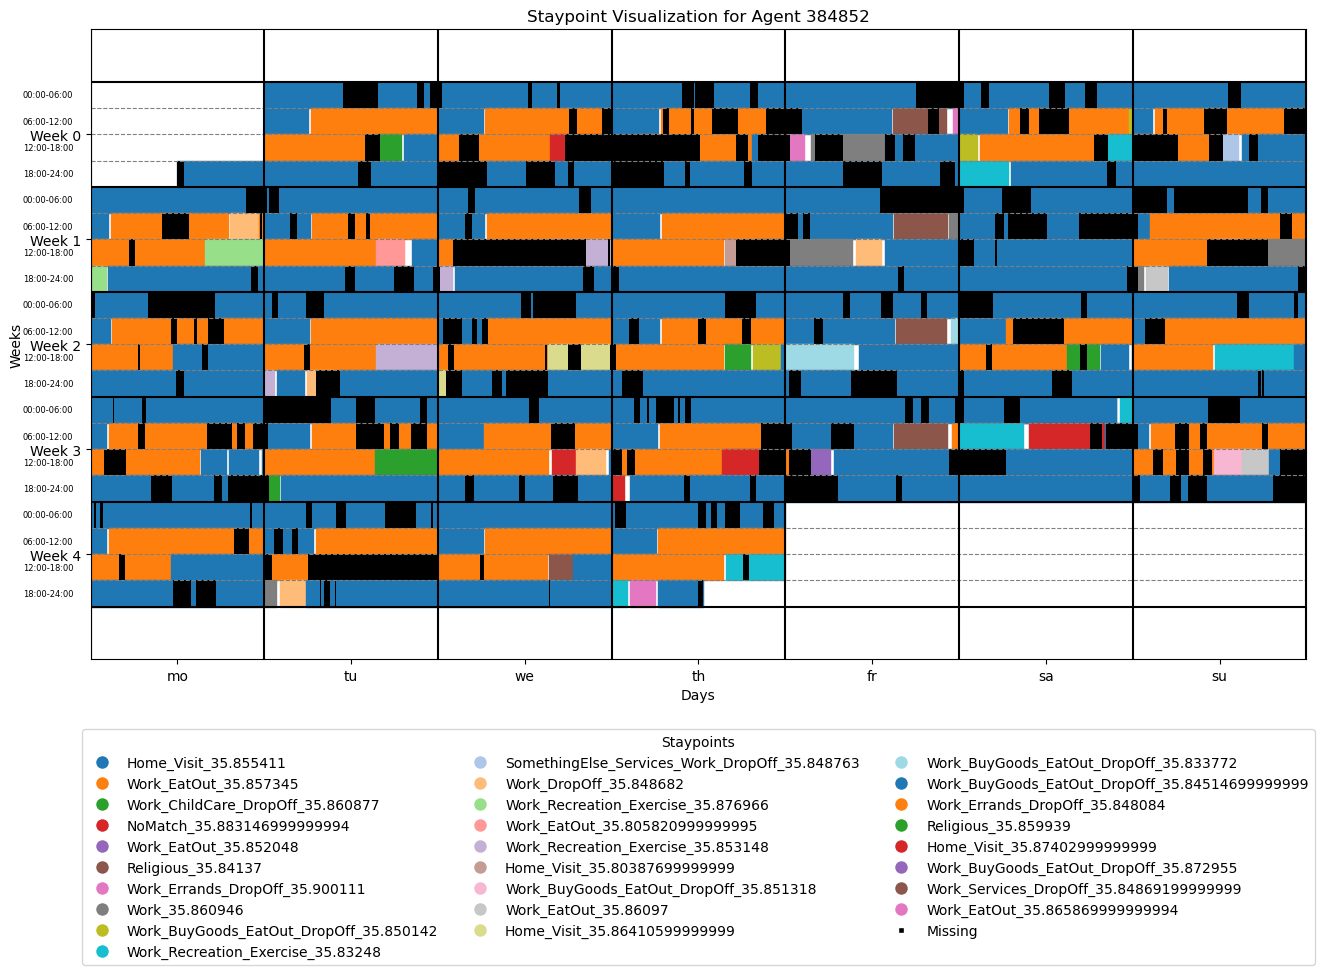

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkb
from matplotlib.lines import Line2D

# --------------------------
# 1. Data Loading & Cleaning for Staypoints
# --------------------------
def set_up_df(agent_id):
    file_path = "/Users/mauryan/Desktop/CalenderPlot_Trial3_GTStaypointsvsMissing/agent_384852_GTStaypoints.parquet"
    df = pd.read_parquet(file_path)
    df = pd.DataFrame(df)
    
    # Convert binary geometry using wkb.loads
    df['geometry'] = df['geometry'].apply(lambda x: wkb.loads(x) if pd.notnull(x) else None)
    
    # Keep only Point geometries (drop LineStrings)
    df = df[df['geometry'].apply(lambda geom: geom is not None and geom.geom_type == "Point")]
    
    # Extract longitude and latitude from geometry
    df['longitude'] = df['geometry'].apply(lambda geom: geom.x)
    df['latitude'] = df['geometry'].apply(lambda geom: geom.y)
    
    # Filter by agent id
    df = df[df['agent_uid'] == agent_id]
    return df

# --------------------------------
# 2. Time Slot & Week/Day Assignments for Staypoints
# --------------------------------
def assign_time_slot_start(row):
    hour = row['timestamp_start'].hour
    if 0 <= hour < 6:
        return 1
    elif 6 <= hour < 12:
        return 2
    elif 12 <= hour < 18:
        return 3
    else:
        return 4

def assign_time_slot_end(row):
    hour = row['timestamp_end'].hour
    if 0 <= hour < 6:
        return 1
    elif 6 <= hour < 12:
        return 2
    elif 12 <= hour < 18:
        return 3
    else:
        return 4

def update_start_ends(df):
    df['timestamp_start'] = pd.to_datetime(df['timestamp_start'])
    df['timestamp_end'] = pd.to_datetime(df['timestamp_end'])
    
    df['time_slot'] = df.apply(assign_time_slot_start, axis=1)
    df['time_slot_end'] = df.apply(assign_time_slot_end, axis=1)
    df['week'] = df['timestamp_start'].dt.isocalendar().week
    df['end_week'] = df['timestamp_end'].dt.isocalendar().week
    df['day'] = df['timestamp_start'].dt.day_name().str[:2].str.lower()
    df['end_day'] = df['timestamp_end'].dt.day_name().str[:2].str.lower()
    df.loc[df['week'] == 52, 'week'] = 0

# --------------------------------
# 3. Semantic Label Modification for Staypoints
# --------------------------------
def modify_semantic_label(row):
    label = row['semantic_label'] if pd.notnull(row['semantic_label']) else "unknown"
    return f"{label}_{row['longitude']}"

# --------------------------
# 4. Compute Missing Timestamps from Noisy Trajectory
# --------------------------
def get_missing_holdout_df(noised_path, simulation_window, freq='3S'):
    df_noised = pd.read_parquet(noised_path)
    df_noised['timestamp'] = pd.to_datetime(df_noised['timestamp'])
    
    start_time = pd.to_datetime(simulation_window["begin"])
    end_time = pd.to_datetime(simulation_window["end"])
    full_range = pd.date_range(start=start_time, end=end_time, freq=freq)
    full_range = full_range.tz_localize(None)
    
    actual_timestamps = pd.to_datetime(df_noised['timestamp'].unique())
    if actual_timestamps.tz is not None:
        actual_timestamps = actual_timestamps.tz_localize(None)
    
    missing_timestamps = full_range.difference(actual_timestamps)
    df_missing = pd.DataFrame({'timestamp': missing_timestamps})
    return df_missing

# --------------------------
# 5. Visualization: Staypoints and Overlay Missing Timestamps as Black Rectangles
# --------------------------
def visualize_data(staypoints_df, missing_df, selected_agent):
    # Fixed color palette.
    colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
        "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
        "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
        "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5"
    ]
    
    # Modify semantic labels and assign each a unique color.
    staypoints_df['semantic_label'] = staypoints_df.apply(modify_semantic_label, axis=1)
    unique_labels = staypoints_df['semantic_label'].unique()
    label_color_map = { label: colors[i % len(colors)] for i, label in enumerate(unique_labels) }
    staypoints_df['color'] = staypoints_df['semantic_label'].map(label_color_map)
    
    # Pivot table: rows = week, columns = day (ordered by day_order).
    day_order = ['mo', 'tu', 'we', 'th', 'fr', 'sa', 'su']
    pivot_data = staypoints_df.pivot_table(
        index='week', columns='day',
        values='semantic_label',
        aggfunc=lambda x: ', '.join(x)
    )[day_order]
    
    # Reindex pivot_data to include every week in the range.
    min_week = staypoints_df['week'].min()
    max_week = staypoints_df['week'].max()
    all_weeks = list(range(min_week, max_week + 1))
    pivot_data = pivot_data.reindex(index=all_weeks)
    
    # Relabel weeks in ascending order: earliest week becomes Week 0, next Week 1, etc.
    n_weeks = len(all_weeks)
    new_week_labels = { orig: new for new, orig in enumerate(all_weeks) }
    pivot_data = pivot_data.sort_index(ascending=True)
    
    # Calculate fractional time slot positions.
    staypoints_df['time_slot_start_number'] = staypoints_df['timestamp_start'].dt.hour // 6
    staypoints_df['time_slot_end_number'] = staypoints_df['timestamp_end'].dt.hour // 6
    staypoints_df['time_slot_start'] = (
        (staypoints_df['timestamp_start'].dt.hour / 6)
        + (staypoints_df['timestamp_start'].dt.minute / 360)
        + (staypoints_df['timestamp_start'].dt.second / 2160)
    ) - staypoints_df['time_slot_start_number']
    staypoints_df['time_slot_end'] = (
        (staypoints_df['timestamp_end'].dt.hour / 6)
        + (staypoints_df['timestamp_end'].dt.minute / 360)
        + (staypoints_df['timestamp_end'].dt.second / 2160)
    ) - staypoints_df['time_slot_end_number']
    
    # Helper function for sub-row vertical offset.
    # In this visualization, we want sub-rows (chunks) ordered such that:
    #   chunk 0 (00:00-06:00) is at the TOP of the cell,
    #   chunk 1 (06:00-12:00) is next,
    #   chunk 2 (12:00-18:00) follows,
    #   chunk 3 (18:00-24:00) is at the BOTTOM.
    # Because we later invert the y-axis, we define:
    #   y = cell_row + (chunk_index * 0.25)
    def chunk_y(cell_row, chunk_index):
        return cell_row + (chunk_index * 0.25)
    
    # Create the figure.
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Draw staypoints visualization.
    for orig_week, row_data in pivot_data.iterrows():
        cell_row = new_week_labels[orig_week]
        for j, day in enumerate(day_order):
            ax.add_patch(plt.Rectangle((j, cell_row), 1, 1, fill=False,
                                       edgecolor='none', linewidth=2))
            for k in range(4):
                sp = staypoints_df[
                    (staypoints_df['week'] == orig_week) &
                    (staypoints_df['day'] == day) &
                    (staypoints_df['time_slot_start_number'] == k)
                ]
                for idx, row in sp.iterrows():
                    start_pos = row['time_slot_start']
                    end_pos = row['time_slot_end']
                    x_pos = j + start_pos
                    num_k = row['time_slot_start_number']
                    num_k_end = row['time_slot_end_number']
                    if ((num_k + 1) == num_k_end) and (row['day'] == row['end_day']):
                        ax.add_patch(plt.Rectangle(
                            (x_pos, chunk_y(cell_row, num_k)),
                            1 - start_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                        ax.add_patch(plt.Rectangle(
                            (j, chunk_y(cell_row, num_k_end)),
                            end_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                    elif ((num_k + 2) == num_k_end) and (row['day'] == row['end_day']):
                        ax.add_patch(plt.Rectangle(
                            (x_pos, chunk_y(cell_row, num_k)),
                            1 - start_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                        ax.add_patch(plt.Rectangle(
                            (j, chunk_y(cell_row, num_k_end - 1)),
                            1, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                        ax.add_patch(plt.Rectangle(
                            (j, chunk_y(cell_row, num_k + 1)),
                            end_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                    elif (num_k == num_k_end) and (row['day'] == row['end_day']):
                        rect_width = end_pos - start_pos
                        ax.add_patch(plt.Rectangle(
                            (x_pos, chunk_y(cell_row, num_k)),
                            rect_width, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                    else:
                        l = num_k
                        ax.add_patch(plt.Rectangle(
                            (x_pos, chunk_y(cell_row, l)),
                            1 - start_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                        l += 1
                        r = j
                        new_cell_row = cell_row
                        placeholder_day = day
                        while (l != num_k_end) or (placeholder_day != row['end_day']):
                            if (l == 4) and (placeholder_day != 'su'):
                                l = 0
                                ax.add_patch(plt.Rectangle(
                                    (r + 1, chunk_y(new_cell_row, 0)),
                                    end_pos, 0.25,
                                    color=row["color"], edgecolor='none'
                                ))
                                current_day_index = day_order.index(placeholder_day)
                                next_day_index = (current_day_index + 1) % len(day_order)
                                placeholder_day = day_order[next_day_index]
                                r += 1
                            elif (l == 4) and (placeholder_day == 'su'):
                                l = 0
                                r = 0
                                placeholder_day = 'mo'
                                new_cell_row += 1
                            else:
                                ax.add_patch(plt.Rectangle(
                                    (r, chunk_y(new_cell_row, l)),
                                    1, 0.25,
                                    color=row["color"], edgecolor='none'
                                ))
                                l += 1
                        ax.add_patch(plt.Rectangle(
                            (r, chunk_y(new_cell_row, l)),
                            end_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
    
    # ---------------------------
    # Overlay Missing Timestamps as Black Rectangles
    # ---------------------------
    # Process missing_df to compute coordinates in the same coordinate system.
    missing_df = missing_df.copy()
    missing_df['timestamp'] = pd.to_datetime(missing_df['timestamp'])
    missing_df['week'] = missing_df['timestamp'].dt.isocalendar().week
    missing_df.loc[missing_df['week'] == 52, 'week'] = 0
    missing_df['day'] = missing_df['timestamp'].dt.day_name().str[:2].str.lower()
    missing_df['time_slot_start_number'] = missing_df['timestamp'].dt.hour // 6
    missing_df['time_slot_offset'] = (
        (missing_df['timestamp'].dt.hour / 6) +
        (missing_df['timestamp'].dt.minute / 360) +
        (missing_df['timestamp'].dt.second / 2160)
    ) - missing_df['time_slot_start_number']
    
    missing_df['day_index'] = missing_df['day'].apply(lambda d: day_order.index(d) if d in day_order else np.nan)
    missing_df['cell_row'] = missing_df['week'].map(new_week_labels)
    
    # x coordinate: day index + fractional offset.
    missing_df['x_coord'] = missing_df['day_index'] + missing_df['time_slot_offset']
    # y coordinate: cell row + (time_slot_start_number * 0.25)
    missing_df['y_coord'] = missing_df['cell_row'] + (missing_df['time_slot_start_number'] * 0.25)
    
    # Instead of drawing small dots, draw a black rectangle that spans the entire sub-row height (0.25).
    rect_width = 0.01  # Adjust as needed
    rect_height = 0.25  # Full sub-row height
    for _, mrow in missing_df.iterrows():
        x = mrow['x_coord'] - rect_width/2
        # Use y_coord directly as the lower boundary of the sub-row.
        y = mrow['y_coord']
        ax.add_patch(plt.Rectangle((x, y), rect_width, rect_height, color='black', ec='none'))
    
    # ---------------------------
    # Draw delineation lines
    # ---------------------------
    ax.set_ylim(-0.5, n_weeks + 0.5)
    for row_i in range(n_weeks + 1):
        ax.axhline(y=row_i, color='black', linewidth=1.5)
    for row_i in range(n_weeks):
        for sub in [0.25, 0.5, 0.75]:
            ax.axhline(y=row_i + sub, color='gray', linestyle='--', linewidth=0.8)
    for day_index in range(len(day_order) + 1):
        ax.axvline(x=day_index, color='black', linewidth=1.5)
    
    ax.set_xlim(0, len(day_order))
    ax.set_xticks(np.arange(len(day_order)) + 0.5)
    ax.set_xticklabels(day_order)
    
    ax.set_yticks(np.arange(n_weeks) + 0.5)
    new_labels = [f"Week {new_week_labels[orig]}" for orig in sorted(new_week_labels.keys())]
    ax.set_yticklabels(new_labels)
    
    ax.set_xlabel('Days')
    ax.set_ylabel('Weeks')
    ax.set_title(f"Staypoint Visualization for Agent {selected_agent}")
    
    legend_elements = [
        Line2D([0], [0], marker='o', color='w',
               markerfacecolor=label_color_map[label],
               markersize=10, label=label)
        for label in unique_labels
    ]
    legend_elements.append(Line2D([0], [0], marker='s', color='w',
                                   markerfacecolor='black',
                                   markersize=5, label='Missing'))
    ax.legend(handles=legend_elements, title="Staypoints",
              loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    
    ax.invert_yaxis()
    
    # ---------------------------
    # Add Time Block Labels next to each sub-row.
    # ---------------------------
    time_labels = ["00:00-06:00", "06:00-12:00", "12:00-18:00", "18:00-24:00"]
    for orig_week in all_weeks:
        cell_row = new_week_labels[orig_week]
        for chunk in range(4):
            y_mid = cell_row + (chunk * 0.25) + 0.125
            ax.text(-0.1, y_mid, time_labels[chunk], va='center', ha='right', fontsize=6, color='black')
    
    plt.tight_layout()
    plt.show()

# --------------------------
# Main Execution
# --------------------------
if __name__ == "__main__":
    selected_agent = 384852
    simulation_window = {
        "begin": "2024-09-30T21:00:00Z",
        "end": "2024-10-31T20:59:57Z"
    }
    
    # Load staypoints.
    df_staypoints = set_up_df(selected_agent)
    update_start_ends(df_staypoints)
    
    # Get missing timestamps from the noisy raw trajectory.
    noisy_file = "/Users/mauryan/Desktop/CalenderPlot_Trial3_GTStaypointsvsMissing/agent_384852_noisyrawtraj.zstd.parquet"
    df_missing = get_missing_holdout_df(noisy_file, simulation_window, freq='3S')
    
    # Visualize staypoints with missing timestamps overlaid as black rectangles.
    visualize_data(df_staypoints, df_missing, selected_agent)


/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/1660621361.py:213: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(
/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/1660621361.py:225: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(
/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/1660621361.py:240: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(
/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/1660621361.py:246: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle(
/var/folders/jh/lzmbq_qd4598nld033t9wsw00000gn/T/ipykernel_70464/1660621361.py:178: UserWarning: Setting the 'color' property will override the edgecolor or facecol

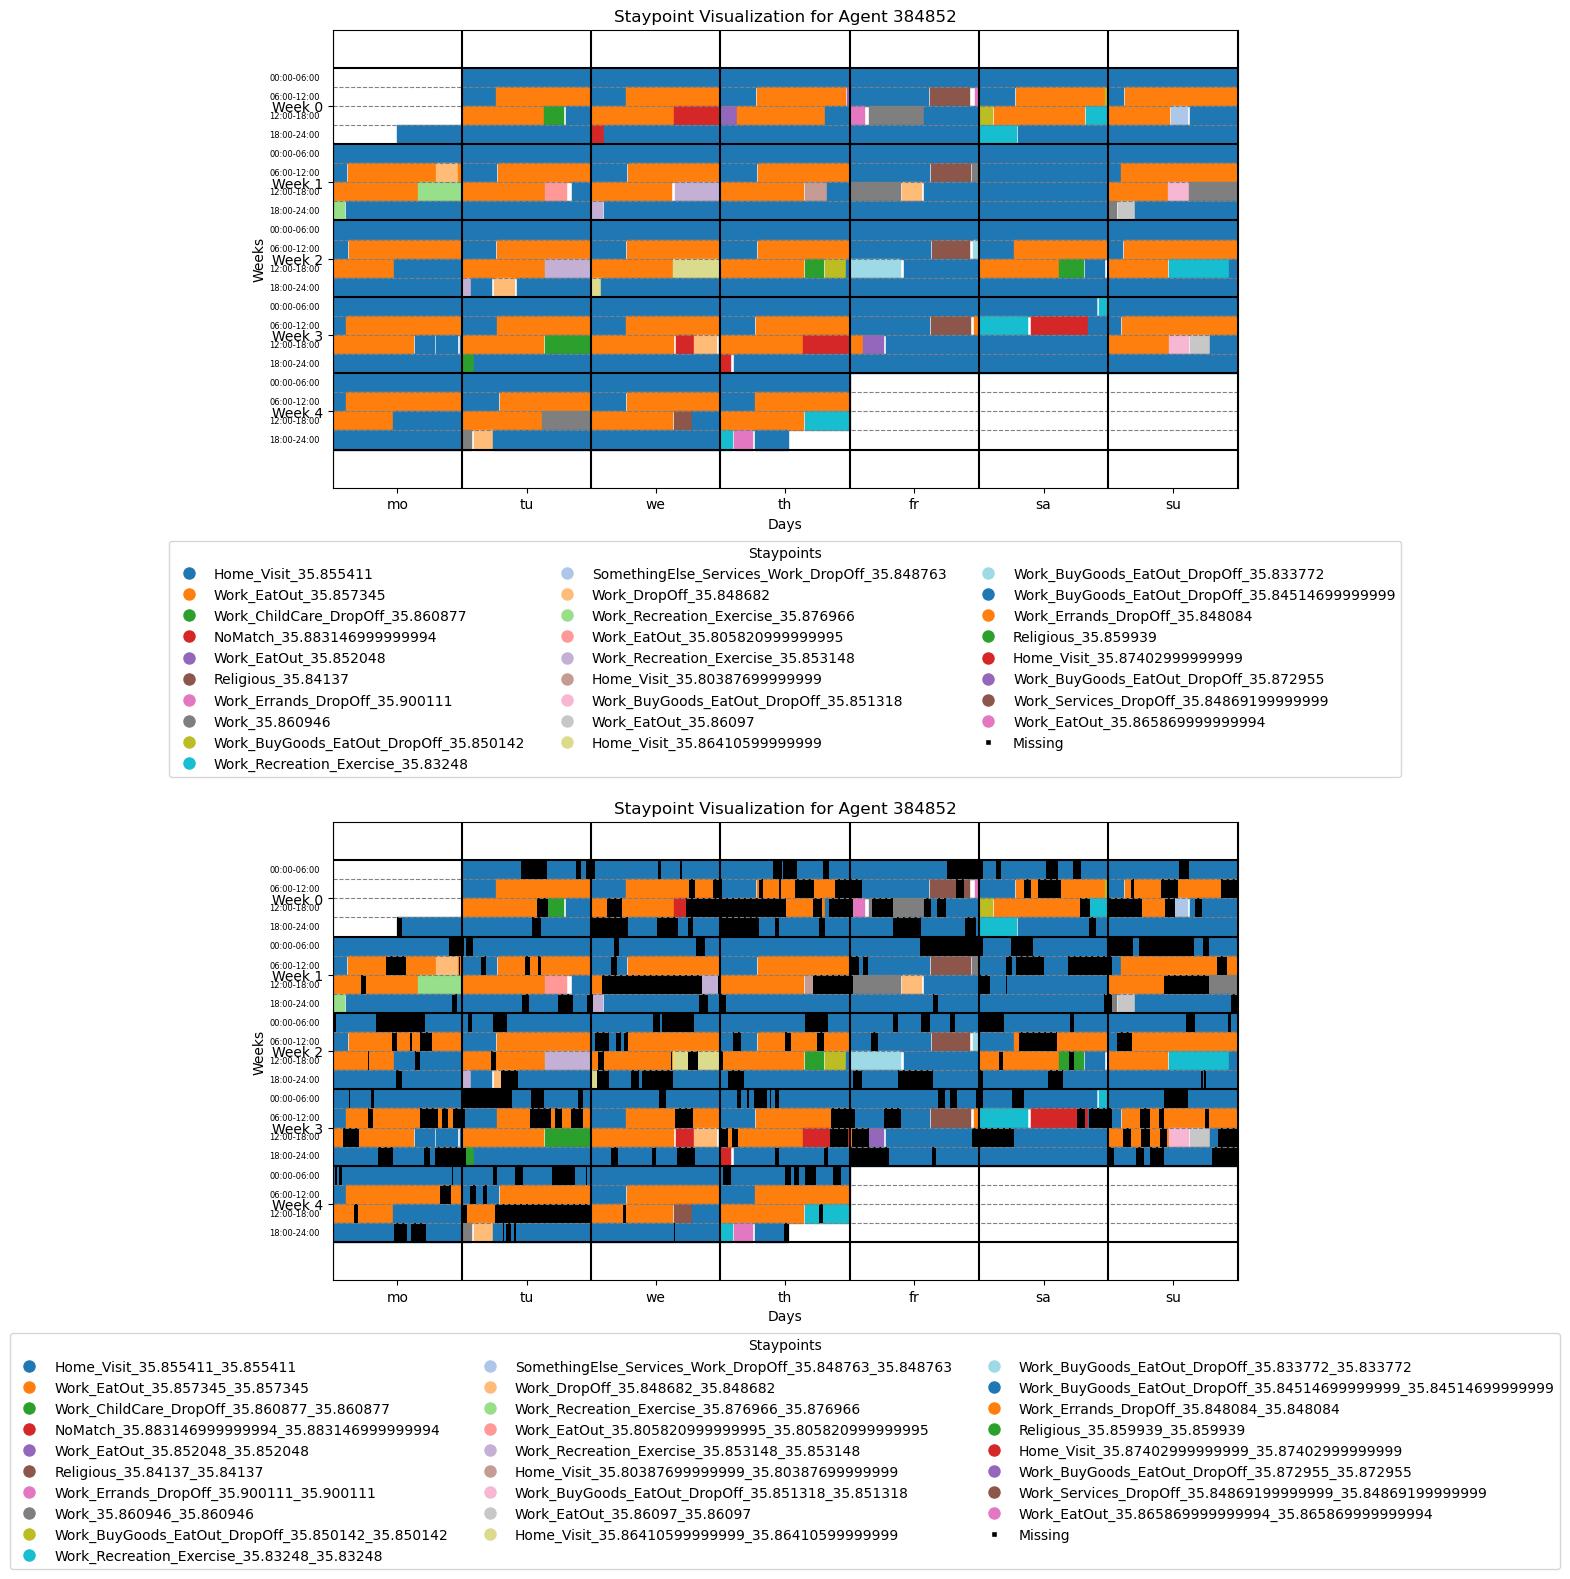

In [18]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkb
from matplotlib.lines import Line2D

# --------------------------
# 1. Data Loading & Cleaning for Staypoints
# --------------------------
def set_up_df(agent_id):
    file_path = "/Users/mauryan/Desktop/CalenderPlot_Trial3_GTStaypointsvsMissing/agent_384852_GTStaypoints.parquet"
    df = pd.read_parquet(file_path)
    df = pd.DataFrame(df)
    
    # Convert binary geometry using wkb.loads
    df['geometry'] = df['geometry'].apply(lambda x: wkb.loads(x) if pd.notnull(x) else None)
    
    # Keep only Point geometries (drop LineStrings)
    df = df[df['geometry'].apply(lambda geom: geom is not None and geom.geom_type == "Point")]
    
    # Extract longitude and latitude
    df['longitude'] = df['geometry'].apply(lambda geom: geom.x)
    df['latitude'] = df['geometry'].apply(lambda geom: geom.y)
    
    # Filter by agent id
    df = df[df['agent_uid'] == agent_id]
    return df

# --------------------------------
# 2. Time Slot & Week/Day Assignments for Staypoints
# --------------------------------
def assign_time_slot_start(row):
    hour = row['timestamp_start'].hour
    if 0 <= hour < 6:
        return 1
    elif 6 <= hour < 12:
        return 2
    elif 12 <= hour < 18:
        return 3
    else:
        return 4

def assign_time_slot_end(row):
    hour = row['timestamp_end'].hour
    if 0 <= hour < 6:
        return 1
    elif 6 <= hour < 12:
        return 2
    elif 12 <= hour < 18:
        return 3
    else:
        return 4

def update_start_ends(df):
    df['timestamp_start'] = pd.to_datetime(df['timestamp_start'])
    df['timestamp_end'] = pd.to_datetime(df['timestamp_end'])
    
    df['time_slot'] = df.apply(assign_time_slot_start, axis=1)
    df['time_slot_end'] = df.apply(assign_time_slot_end, axis=1)
    df['week'] = df['timestamp_start'].dt.isocalendar().week
    df['end_week'] = df['timestamp_end'].dt.isocalendar().week
    df['day'] = df['timestamp_start'].dt.day_name().str[:2].str.lower()
    df['end_day'] = df['timestamp_end'].dt.day_name().str[:2].str.lower()
    df.loc[df['week'] == 52, 'week'] = 0

# --------------------------------
# 3. Semantic Label Modification for Staypoints
# --------------------------------
def modify_semantic_label(row):
    label = row['semantic_label'] if pd.notnull(row['semantic_label']) else "unknown"
    return f"{label}_{row['longitude']}"

# --------------------------
# 4. Compute Missing Timestamps from Noisy Trajectory
# --------------------------
def get_missing_holdout_df(noised_path, simulation_window, freq='3S'):
    df_noised = pd.read_parquet(noised_path)
    df_noised['timestamp'] = pd.to_datetime(df_noised['timestamp'])
    
    start_time = pd.to_datetime(simulation_window["begin"])
    end_time = pd.to_datetime(simulation_window["end"])
    full_range = pd.date_range(start=start_time, end=end_time, freq=freq)
    full_range = full_range.tz_localize(None)
    
    actual_timestamps = pd.to_datetime(df_noised['timestamp'].unique())
    if actual_timestamps.tz is not None:
        actual_timestamps = actual_timestamps.tz_localize(None)
    
    missing_timestamps = full_range.difference(actual_timestamps)
    df_missing = pd.DataFrame({'timestamp': missing_timestamps})
    return df_missing

# --------------------------
# 5. Visualization Function
# --------------------------
def visualize_data(staypoints_df, selected_agent, missing_df=None, ax=None):
    """
    Plots staypoints. If missing_df is provided, overlays missing timestamps.
    If ax is provided, draws on that Axes; otherwise creates a new figure/axes.
    """
    # If no Axes object is provided, create one
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 10))
    
    # Fixed color palette.
    colors = [
        "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
        "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
        "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
        "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5"
    ]
    
    # Modify semantic labels and assign each a unique color.
    staypoints_df['semantic_label'] = staypoints_df.apply(modify_semantic_label, axis=1)
    unique_labels = staypoints_df['semantic_label'].unique()
    label_color_map = { label: colors[i % len(colors)] for i, label in enumerate(unique_labels) }
    staypoints_df['color'] = staypoints_df['semantic_label'].map(label_color_map)
    
    # Pivot table: rows = week, columns = day (ordered by day_order).
    day_order = ['mo', 'tu', 'we', 'th', 'fr', 'sa', 'su']
    pivot_data = staypoints_df.pivot_table(
        index='week', columns='day',
        values='semantic_label',
        aggfunc=lambda x: ', '.join(x)
    )[day_order]
    
    # Reindex pivot_data to include every week in the range.
    min_week = staypoints_df['week'].min()
    max_week = staypoints_df['week'].max()
    all_weeks = list(range(min_week, max_week + 1))
    pivot_data = pivot_data.reindex(index=all_weeks)
    
    # Relabel weeks in ascending order: earliest week becomes Week 0, next Week 1, etc.
    n_weeks = len(all_weeks)
    new_week_labels = { orig: new for new, orig in enumerate(all_weeks) }
    pivot_data = pivot_data.sort_index(ascending=True)
    
    # Calculate fractional time slot positions for staypoints.
    staypoints_df['time_slot_start_number'] = staypoints_df['timestamp_start'].dt.hour // 6
    staypoints_df['time_slot_end_number'] = staypoints_df['timestamp_end'].dt.hour // 6
    staypoints_df['time_slot_start'] = (
        (staypoints_df['timestamp_start'].dt.hour / 6)
        + (staypoints_df['timestamp_start'].dt.minute / 360)
        + (staypoints_df['timestamp_start'].dt.second / 2160)
    ) - staypoints_df['time_slot_start_number']
    staypoints_df['time_slot_end'] = (
        (staypoints_df['timestamp_end'].dt.hour / 6)
        + (staypoints_df['timestamp_end'].dt.minute / 360)
        + (staypoints_df['timestamp_end'].dt.second / 2160)
    ) - staypoints_df['time_slot_end_number']
    
    # Helper function for sub-row vertical offset (0..0.75).
    def chunk_y(cell_row, chunk_index):
        return cell_row + (chunk_index * 0.25)
    
    # Draw the staypoints visualization.
    for orig_week, row_data in pivot_data.iterrows():
        cell_row = new_week_labels[orig_week]
        for j, day in enumerate(day_order):
            ax.add_patch(plt.Rectangle((j, cell_row), 1, 1, fill=False,
                                       edgecolor='none', linewidth=2))
            for k in range(4):
                sp = staypoints_df[
                    (staypoints_df['week'] == orig_week) &
                    (staypoints_df['day'] == day) &
                    (staypoints_df['time_slot_start_number'] == k)
                ]
                for idx, row in sp.iterrows():
                    start_pos = row['time_slot_start']
                    end_pos = row['time_slot_end']
                    x_pos = j + start_pos
                    num_k = row['time_slot_start_number']
                    num_k_end = row['time_slot_end_number']
                    if ((num_k + 1) == num_k_end) and (row['day'] == row['end_day']):
                        ax.add_patch(plt.Rectangle(
                            (x_pos, chunk_y(cell_row, num_k)),
                            1 - start_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                        ax.add_patch(plt.Rectangle(
                            (j, chunk_y(cell_row, num_k_end)),
                            end_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                    elif ((num_k + 2) == num_k_end) and (row['day'] == row['end_day']):
                        ax.add_patch(plt.Rectangle(
                            (x_pos, chunk_y(cell_row, num_k)),
                            1 - start_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                        ax.add_patch(plt.Rectangle(
                            (j, chunk_y(cell_row, num_k_end - 1)),
                            1, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                        ax.add_patch(plt.Rectangle(
                            (j, chunk_y(cell_row, num_k + 1)),
                            end_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                    elif (num_k == num_k_end) and (row['day'] == row['end_day']):
                        rect_width = end_pos - start_pos
                        ax.add_patch(plt.Rectangle(
                            (x_pos, chunk_y(cell_row, num_k)),
                            rect_width, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                    else:
                        l = num_k
                        ax.add_patch(plt.Rectangle(
                            (x_pos, chunk_y(cell_row, l)),
                            1 - start_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
                        l += 1
                        r = j
                        new_cell_row = cell_row
                        placeholder_day = day
                        while (l != num_k_end) or (placeholder_day != row['end_day']):
                            if (l == 4) and (placeholder_day != 'su'):
                                l = 0
                                ax.add_patch(plt.Rectangle(
                                    (r + 1, chunk_y(new_cell_row, 0)),
                                    end_pos, 0.25,
                                    color=row["color"], edgecolor='none'
                                ))
                                current_day_index = day_order.index(placeholder_day)
                                next_day_index = (current_day_index + 1) % len(day_order)
                                placeholder_day = day_order[next_day_index]
                                r += 1
                            elif (l == 4) and (placeholder_day == 'su'):
                                l = 0
                                r = 0
                                placeholder_day = 'mo'
                                new_cell_row += 1
                            else:
                                ax.add_patch(plt.Rectangle(
                                    (r, chunk_y(new_cell_row, l)),
                                    1, 0.25,
                                    color=row["color"], edgecolor='none'
                                ))
                                l += 1
                        ax.add_patch(plt.Rectangle(
                            (r, chunk_y(new_cell_row, l)),
                            end_pos, 0.25,
                            color=row["color"], edgecolor='none'
                        ))
    
    # Overlay missing timestamps if provided
    if missing_df is not None:
        # Filter missing timestamps to only the weeks that exist in staypoints
        missing_df = missing_df.copy()
        missing_df['timestamp'] = pd.to_datetime(missing_df['timestamp'])
        missing_df['week'] = missing_df['timestamp'].dt.isocalendar().week
        missing_df.loc[missing_df['week'] == 52, 'week'] = 0
        # Only keep missing timestamps in the same range of weeks
        missing_df = missing_df[missing_df['week'].isin(all_weeks)]
        
        missing_df['day'] = missing_df['timestamp'].dt.day_name().str[:2].str.lower()
        missing_df['time_slot_start_number'] = missing_df['timestamp'].dt.hour // 6
        missing_df['time_slot_offset'] = (
            (missing_df['timestamp'].dt.hour / 6) +
            (missing_df['timestamp'].dt.minute / 360) +
            (missing_df['timestamp'].dt.second / 2160)
        ) - missing_df['time_slot_start_number']
        
        missing_df['day_index'] = missing_df['day'].apply(lambda d: day_order.index(d) if d in day_order else np.nan)
        missing_df['cell_row'] = missing_df['week'].map(new_week_labels)
        missing_df['x_coord'] = missing_df['day_index'] + missing_df['time_slot_offset']
        missing_df['y_coord'] = missing_df['cell_row'] + (missing_df['time_slot_start_number'] * 0.25)
        
        # Draw black rectangles that extend the full sub-row height (0.25).
        rect_width = 0.01  # adjust as needed
        rect_height = 0.25  # full sub-row height
        for _, mrow in missing_df.iterrows():
            x = mrow['x_coord'] - rect_width/2
            y = mrow['y_coord']  # lower boundary of the sub-row
            ax.add_patch(plt.Rectangle((x, y), rect_width, rect_height, color='black', ec='none'))
    
    # Delineation lines
    ax.set_ylim(-0.5, n_weeks + 0.5)
    for row_i in range(n_weeks + 1):
        ax.axhline(y=row_i, color='black', linewidth=1.5)
    for row_i in range(n_weeks):
        for sub in [0.25, 0.5, 0.75]:
            ax.axhline(y=row_i + sub, color='gray', linestyle='--', linewidth=0.8)
    for day_index in range(len(day_order) + 1):
        ax.axvline(x=day_index, color='black', linewidth=1.5)
    
    ax.set_xlim(0, len(day_order))
    ax.set_xticks(np.arange(len(day_order)) + 0.5)
    ax.set_xticklabels(day_order)
    
    ax.set_yticks(np.arange(n_weeks) + 0.5)
    new_labels = [f"Week {new_week_labels[orig]}" for orig in sorted(new_week_labels.keys())]
    ax.set_yticklabels(new_labels)
    
    ax.set_xlabel('Days')
    ax.set_ylabel('Weeks')
    ax.set_title(f"Staypoint Visualization for Agent {selected_agent}")
    
    legend_elements = [
        Line2D([0], [0], marker='o', color='w',
               markerfacecolor=label_color_map[label],
               markersize=10, label=label)
        for label in unique_labels
    ]
    legend_elements.append(Line2D([0], [0], marker='s', color='w',
                                   markerfacecolor='black',
                                   markersize=5, label='Missing'))
    ax.legend(handles=legend_elements, title="Staypoints",
              loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    
    ax.invert_yaxis()
    
    # Add Time Block Labels next to each sub-row
    time_labels = ["00:00-06:00", "06:00-12:00", "12:00-18:00", "18:00-24:00"]
    for orig_week in all_weeks:
        cell_row = new_week_labels[orig_week]
        for chunk in range(4):
            y_mid = cell_row + (chunk * 0.25) + 0.125
            ax.text(-0.1, y_mid, time_labels[chunk], va='center', ha='right', fontsize=6, color='black')

    return ax  # Return the Axes object for further manipulation if needed

# --------------------------
# Main Execution
# --------------------------
if __name__ == "__main__":
    # Optional: Suppress some matplotlib warnings
    # import warnings
    # warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

    selected_agent = 384852
    simulation_window = {
        "begin": "2024-09-30T21:00:00Z",
        "end": "2024-10-31T20:59:57Z"
    }
    
    # Load staypoints data.
    df_staypoints = set_up_df(selected_agent)
    update_start_ends(df_staypoints)
    
    # Get missing timestamps from the noisy raw trajectory.
    noisy_file = "/Users/mauryan/Desktop/CalenderPlot_Trial3_GTStaypointsvsMissing/agent_384852_noisyrawtraj.zstd.parquet"
    df_missing = get_missing_holdout_df(noisy_file, simulation_window, freq='3S')
    
    # Create a figure with two subplots stacked vertically
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))
    
    # First subplot: Only staypoints
    visualize_data(df_staypoints, selected_agent, missing_df=None, ax=ax1)
    
    # Second subplot: Staypoints + missing timestamps
    visualize_data(df_staypoints, selected_agent, missing_df=df_missing, ax=ax2)
    
    plt.tight_layout()
    plt.show()
